## Import necessary packages

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package
import pandas as pd
import numpy as np

# Data Visualisation
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Read csv file and store in pandas Dataframe

In [3]:
path = "/content/Uber Request Data.csv"
df=pd.read_csv(path)

## Dataframe

In [4]:
df

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,2905,City,1.0,Cancelled,13-07-2016 06:08:41,NaN
...,...,...,...,...,...,...
6740,6745,City,NaN,No Cars Available,15-07-2016 23:49:03,NaN
6741,6752,Airport,NaN,No Cars Available,15-07-2016 23:50:05,NaN
6742,6751,City,NaN,No Cars Available,15-07-2016 23:52:06,NaN
6743,6754,City,NaN,No Cars Available,15-07-2016 23:54:39,NaN


## Convert timestamp into datetime object

In [5]:
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'])
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'])
df['Trip Duration']= np.round((df['Drop timestamp']-df['Request timestamp']).dt.total_seconds()/600)*10
df['Trip Duration'] = pd.to_numeric(df['Trip Duration'], errors='coerce').astype(np.float64).fillna(0)

In [6]:
df['Request Date']=df['Request timestamp'].dt.date
df['Request Time']=df['Request timestamp'].dt.time
df['Request Hour']=df['Request timestamp'].dt.hour
df.drop(['Request timestamp','Drop timestamp'], axis=1, inplace=True)

## Trip Status v/s no. of trips

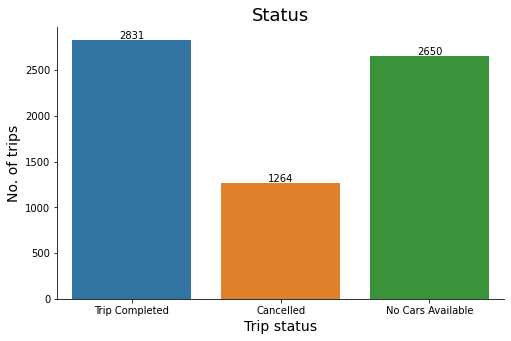

In [7]:
plt.figure(figsize=(8, 5))
g = sns.countplot(x="Status", data=df)
sns.despine()
plt.title("Status", fontsize = 18)
plt.xlabel("Trip status", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 50), ha = 'center', va = 'center')
plt.show()

### Remarks:
The drivers are cancelling almost 40% of the trips.
There is a shortage of cab partners

## Check distribution of data for different dates if it is similar

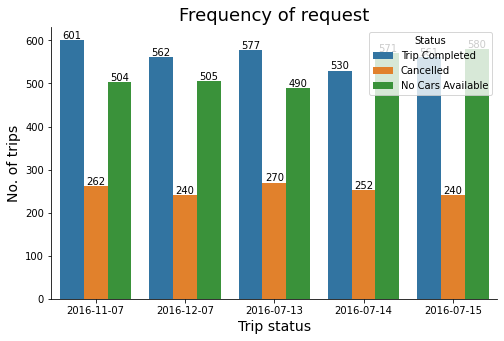

In [8]:
plt.figure(figsize=(8, 5))
g = sns.countplot(x="Request Date", hue="Status", data=df)
sns.despine()
plt.title("Frequency of request", fontsize = 18)
plt.xlabel("Trip status", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 10), ha = 'center', va = 'center')
plt.show()

### Remarks:
The data for different days is similar therefore there is no impact of any festival or any special occasion on the data.

## Check whether Pickup point affects Trip Status

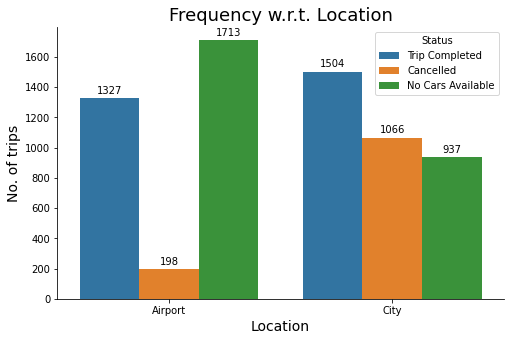

In [9]:
plt.figure(figsize=(8, 5))
g=sns.countplot("Pickup point", hue="Status", data=df)
sns.despine()
plt.title("Frequency w.r.t. Location", fontsize = 18)
plt.xlabel("Location", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 50), ha = 'center', va = 'center')
plt.show()

### Remarks:
Cancellation rate in City is much greater than that observed in Airport as Pickup point

## Check distribution with Trip Duration

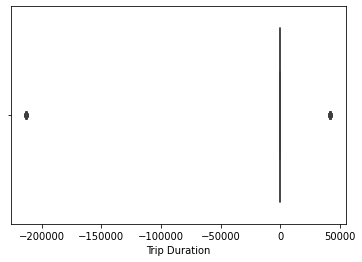

In [10]:
sns.boxplot(x = "Trip Duration", data = df)

In [11]:
#Remove Outliers
Q1 = 0
Q3 = df["Trip Duration"].quantile(0.75)
IQR = Q3-Q1
time = df[(df["Trip Duration"] > 0) & (df["Trip Duration"] <= Q3 + 1.5*IQR)]

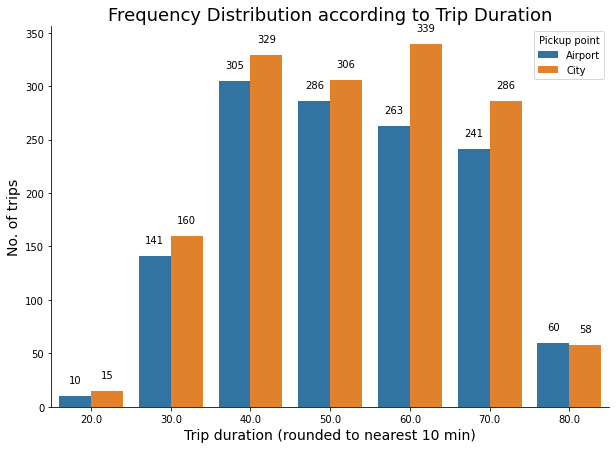

In [12]:
plt.figure(figsize=(10, 7))
g=sns.countplot("Trip Duration", hue="Pickup point", data=time)
sns.despine()
plt.title("Frequency Distribution according to Trip Duration", fontsize = 18)
plt.xlabel("Trip duration (rounded to nearest 10 min)", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 15), ha = 'center', va = 'center')
plt.show()

### Remarks: 
People Prefer to take a ride to places which take around 40 to 70 minutes.

### Assess Behavior of Cab Drivers

In [13]:
df_driver=df
df_driver['Driver id']=pd.to_numeric(df['Driver id'], errors='coerce').astype(np.float64).dropna()
df.drop(['Request id','Request Time'], axis=1, inplace=True)
status = pd.get_dummies(df_driver['Status'], drop_first = False)
df_driver = pd.concat([df_driver, status], axis = 1)

df1=df_driver.groupby('Driver id')[['Trip Completed','Cancelled']].sum()
df1['Total Request']=(df1['Trip Completed']+df1['Cancelled'])
df1['Ratio']=df1['Cancelled']/df1['Total Request']*100
df1.sort_values(["Ratio",'Trip Completed'], axis=0, ascending=False, inplace=True)

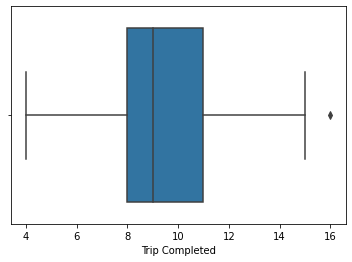

In [14]:
sns.boxplot("Trip Completed", data = df1)

In [15]:
df1.describe()

,Trip Completed,Cancelled,Total Request,Ratio
count,300.000000,300.000000,300.000000,300.000000
mean,9.436667,4.213333,13.650000,30.443695
std,2.458891,1.998617,3.015151,12.176689
min,4.000000,0.000000,6.000000,0.000000
25%,8.000000,3.000000,12.000000,22.222222
50%,9.000000,4.000000,13.500000,29.705882
75%,11.000000,5.000000,16.000000,38.461538
max,16.000000,12.000000,22.000000,60.000000


## Drivers Performing there jobs Poorly 

In [16]:
relaxation=.66 #b/w 0.5-1
driver_belowavg=df1[(df1["Trip Completed"] < relaxation*df1["Trip Completed"].mean()) & (df1["Cancelled"] > relaxation*df1["Cancelled"].mean()) & ((df1["Ratio"] > df1["Ratio"].mean()) | (df1["Total Request"] < relaxation*df1["Total Request"].mean()))]
driver_belowavg

,Trip Completed,Cancelled,Total Request,Ratio
Driver id,,,,
267.0,6,9,15,60.000000
103.0,5,7,12,58.333333
104.0,5,7,12,58.333333
131.0,6,8,14,57.142857
135.0,5,6,11,54.545455
62.0,6,7,13,53.846154
229.0,6,7,13,53.846154
39.0,6,6,12,50.000000
165.0,6,6,12,50.000000


### Remarks:
1. The Drivers are enlisted keepig in mind various factors such as-'Total Requests', 'Trips Completed', 'Cancellation Ratio' lying below a theshold of 66% of the mean values.
2. Some drivers are going home early or getting involved in other work so they switch off their phones so that they do not receive any trip request.
3. Some are cancelling the trips a lot as compared to other cab partners.
4. The company can give warning/penalty to them or even change these drivers as this is causing a negative immpact on the good will of the company.

## Drivers doing their job well

In [17]:
threshold_no=.2  #b/w 0.0-0.3
driver_aboveavg=df1[(df1["Trip Completed"] > (1+threshold_no)*df1["Trip Completed"].mean()) &  (df1["Ratio"] < (1-threshold_no)*df1["Ratio"].mean())  & (df1["Total Request"] > (1+threshold_no)*df1["Total Request"].mean())]
driver_aboveavg.sort_values(['Trip Completed',"Ratio"], axis=0, ascending=False, inplace=True)
driver_aboveavg

,Trip Completed,Cancelled,Total Request,Ratio
Driver id,,,,
22.0,16,5,21,23.809524
233.0,15,3,18,16.666667
184.0,15,2,17,11.764706
105.0,14,4,18,22.222222
109.0,14,4,18,22.222222
125.0,14,4,18,22.222222
126.0,14,4,18,22.222222
274.0,14,4,18,22.222222
134.0,14,3,17,17.647059


### Remarks:
1. The Drivers are also enlisted keepig in mind various factors such as-'Total Requests', 'Trips Completed', 'Cancellation Ratio'.
3. These drivers are working hard and taking multiple trips so they can be rewarded if it is as per compnay guidelines.


In [18]:
print("Best Performing Drivers-",driver_aboveavg.shape)
print("Poor Performing Drivers-",driver_belowavg.shape)

Best Performing Drivers- (13, 4)
Poor Performing Drivers- (34, 4)


## Analytics of Request Hours for cab booking with Pickup Location

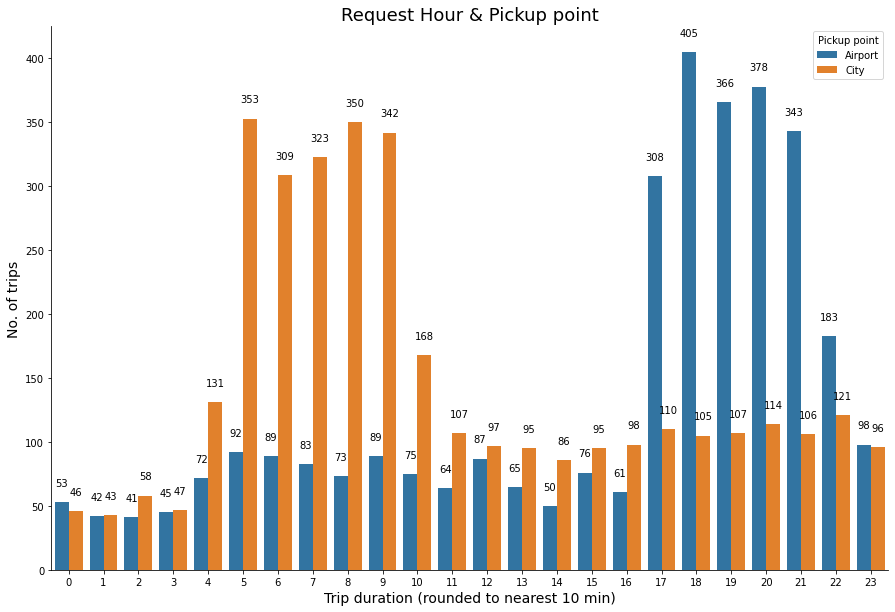

In [19]:
plt.figure(figsize=(15, 10))
g=sns.countplot("Request Hour",hue="Pickup point", data=df)
sns.despine()
plt.title("Request Hour & Pickup point", fontsize = 18)
plt.xlabel("Trip duration (rounded to nearest 10 min)", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 15), ha = 'center', va = 'center')
plt.show()

### Remarks:
#### Peak Booking Hours-
     1. In morning hours between 5am to 9 am in city.
     2. In evening hours between 5pm to 10pm at the airport.

## Analytics of Request Hours for cab booking with Trip Status

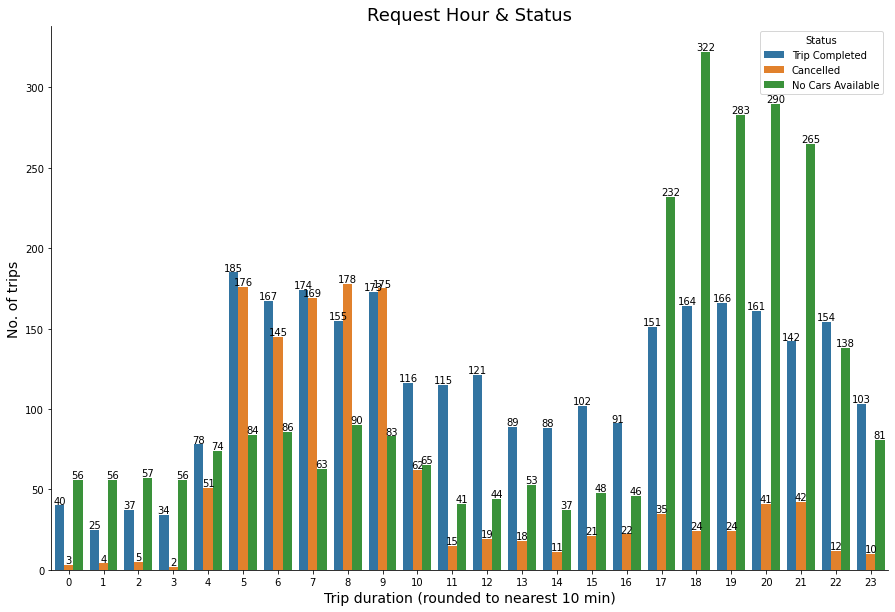

In [20]:
plt.figure(figsize=(15, 10))
g=sns.countplot("Request Hour",hue="Status", data=df)
sns.despine()
plt.title("Request Hour & Status", fontsize = 18)
plt.xlabel("Trip duration (rounded to nearest 10 min)", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 3), ha = 'center', va = 'center')
plt.show()

### Remarks:
1. Cancellation rate in morning hours between 5am to 9am is quite high.
2. Shortage of cabs in the evening hours between 5pm to 9pm, company should increase the no. of cabs in evening hours.

## Analyse Airport Data seperately

In [21]:
df_airport=df[(df["Pickup point"] =='Airport')]

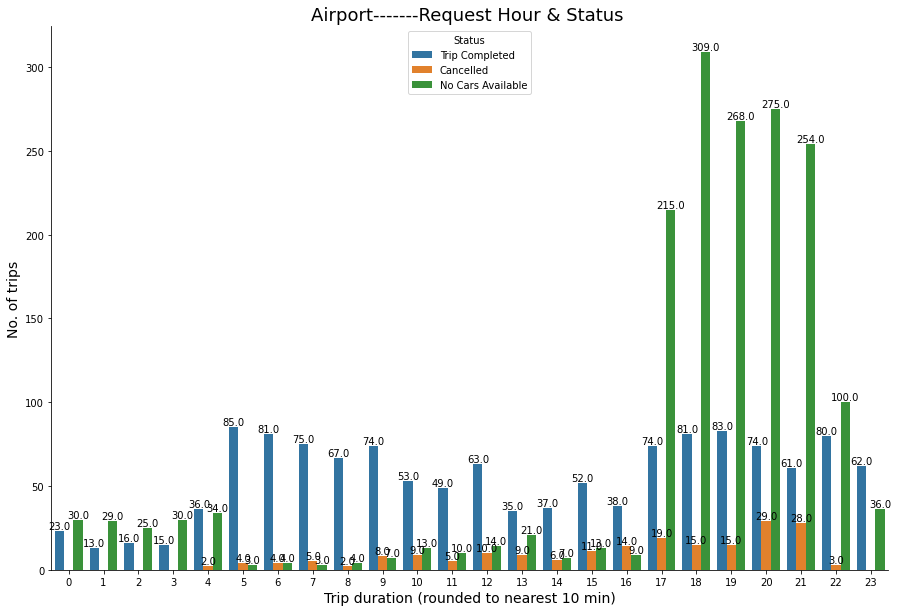

In [22]:
plt.figure(figsize=(15, 10))
g=sns.countplot("Request Hour",hue="Status", data=df_airport)
sns.despine()
plt.title("Airport-------Request Hour & Status ", fontsize = 18)
plt.xlabel("Trip duration (rounded to nearest 10 min)", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 3), ha = 'center', va = 'center')
plt.show()

### Remarks:
 Accute shortage of cabs in the evening hours a the airport, no. of cabs should be increased.

## Analyse Airport Data seperately

In [23]:
df_city=df[(df["Pickup point"] =='City')]

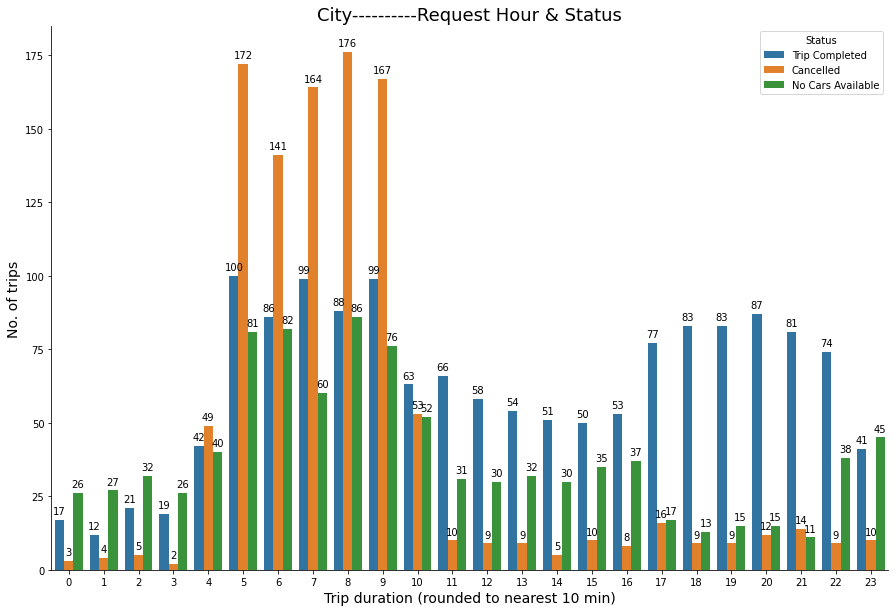

In [24]:
plt.figure(figsize=(15, 10))
g=sns.countplot("Request Hour",hue="Status", data=df_city)
sns.despine()
plt.title("City----------Request Hour & Status", fontsize = 18)
plt.xlabel("Trip duration (rounded to nearest 10 min)", fontsize = 14)
plt.ylabel("No. of trips", fontsize = 14)
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 3), ha = 'center', va = 'center')
plt.show()

### Remarks:
 High cab cancellation ratio in the city in morning hours.

# Summary:
1. Cancellaion rate in city is much greater than that compared at the airport, therefore a proper investigation to be made with the drivers for the reason and act accordingly.
1. Proper Check to be made on cab drivers performing poorly.
2. Cab demand is more in city in morning and more in evening at the airport therefore partners should be handled accordingly
3. Increase cab availabilty at airport in evening.
4. Check why Cab drivers are cancelling rides in morning hors in the city.
